# DeePC on a Double Integrator System
This example will show how to use DeePC to control a double integrator system.

### Setup


In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import numpy as np
from cvxopt import spmatrix, matrix, solvers
from numpy import linalg as nla
from scipy import linalg as sla
from scipy import sparse
from scipy.signal import cont2discrete
from scipy.stats import qmc
from cvxopt.solvers import qp
import cvxpy as cp
from numpy import hstack, inf, ones
from scipy.sparse import vstack
from osqp import OSQP
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import Normalize

from typing import List
from cvxpy.expressions.expression import Expression
from cvxpy.constraints.constraint import Constraint

### Double Integrator System

For this example, we will use a 2D double integrator system:
Using Linear System Dynamics, we can write the system as:
$$ \dot{x} = Ax + Bu $$
$$ y = Cx + Du $$
Where:
- $x$ is the state vector: $x = [p_x, p_y, v_x, v_y]^T$
- $u$ is the control input: $u = [a_x, a_y]^T$
- $y$ is the output vector: $y = [p_x, p_y]^T$
- $A$, $B$, $C$, and $D$ are the system matrices

Since it is a double integrator system, we need to define the following matrices:
$$ B = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1
\end{bmatrix} $$

$$ C = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix} $$

$$ D = 0 $$


In a simple system, without any coupling, the system matrix $A$ can be defined as:
$$ A = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix} $$

However, since it can be interesting to see how the system behaves with coupling, we will skip defining it so that we can test the system with different dynamics.


Discretizing the system: we need to consider going from 
$$\dot{x} = Ax + Bu$$
to
$$x_{k+1} = A_dx_k + B_du_k$$
Let $t_d$ be the sampling time, then we can define the discrete system with:
$$ A_d = e^{At_d} $$
$$ B_d = \int_0^{t_d} e^{A\tau}B d\tau $$

I will be using [cont2discrete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html) from scipy to discretize the system.

In [48]:
class DoubleIntegrator:
	def __init__(self, dt=1, x0=np.zeros(4), 
            A=np.array([[0, 0, 1, 0],
						[0, 0, 0, 1],
						[0, 0, 0, 0],
						[0, 0, 0, 0]]),
            state_box_constraints=np.array([[-5, 25], [-5, 25], [-10, 10], [-10, 10]]),
			input_box_constraints=np.array([[-1, 1], [-1, 1]]),
            mu=np.zeros(4),
            sigma=np.zeros((4, 4))):
		
		self.dt = dt
		self.x = x0.copy()
		self.y = None
		self.A = A
		self.n = int(A.shape[0]/2) # Since its a linear system with px and vx
		# box constraints should be (n, 2) state_box_constraints[:, 0] = lower bounds, state_box_constraints[:, 1] = upper bounds, assert that
		if state_box_constraints is not None:
			assert state_box_constraints.shape[0] == 2*self.n
			assert state_box_constraints.shape[1] == 2
		# else: no box constraints(None)
		self.state_box_constraints = state_box_constraints
		self.input_box_constraints = input_box_constraints
   
		# Construct dynamics for the double integrator
		self.B = np.vstack([np.zeros((self.n, self.n)), np.eye(self.n)])
		# self.C = np.hstack([np.eye(self.n), np.zeros((self.n, self.n))])
		self.C = np.eye(self.x.size)
		self.D = np.zeros((self.x.size, self.n))
		self.y = self.C @ self.x
  
		self.mu = mu
		self.sigma = sigma

		# Discretize the system
		self.Ad, self.Bd, self.Cd, self.Dd, _ = cont2discrete((self.A, self.B, self.C, self.D), dt)
		self.input_shape = self.Bd.shape[1]
		self.state_shape = self.Ad.shape[1]
		self.output_shape = self.Cd.shape[0]
		
		# Cd & Dd should not change
		# set up histories & updates
		self.input_history = []
		self.state_history = []
		self.state_history.append(self.x.copy())
		self.output_history = []
		self.output_history.append(self.y.copy())
  
	def reset(self):
		self.x = np.zeros(self.x.shape)
		self.y = self.Cd @ self.x
		self.input_history = []
		self.state_history = []
		self.state_history.append(self.x.copy())
		self.output_history = []
		self.output_history.append(self.y.copy())
		if self.state_box_constraints is not None:
			assert self.state_box_constraints.shape[0] == 2*self.n
			assert self.state_box_constraints.shape[1] == 2
		
	def set_state(self, x):
		self.x = x.copy()
		self.state_history.append(x.copy())

	def get_state(self):
		return self.x.copy()

	# Simulation Steps:
	def step(self, u):
		# Update the state
		noise = np.random.multivariate_normal(self.mu, self.sigma)
		self.x = self.Ad @ self.x + self.Bd @ u + noise
		self.y = self.Cd @ self.x + self.Dd @ u
		self.state_history.append(self.x.copy())
		self.input_history.append(u.copy())
		self.output_history.append(self.y.copy())
		# if there are box constraints
		no_violation = True
		if self.state_box_constraints is not None:
			# check if the state is within the box constraints, if not, throw a fit
			for i in range(self.n):
				if self.x[i] < self.state_box_constraints[i, 0] or self.x[i] > self.state_box_constraints[i, 1]:
					print("Constraints Violated!!!")
					no_violation = False
		return self.y.copy(), no_violation

	def plot_trajectory(self, fig=None, ax=None, limit_chart=True):
		# if its not 2d, return
		if self.n != 2:
			print("Cannot plot trajectory for non-2D systems")
			return
		if ax is None:
			fig, ax = plt.subplots()

		points = np.array(self.output_history)[:, :2]
		segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
		t = np.linspace(0, 1, len(segments))
		colors = cm.viridis(t)
		# flip the color map
		colors = colors[::-1]
		lc = LineCollection(segments, colors=colors)
		ax.add_collection(lc)

		# Mark start and end points
		# get the beginning color
		# for all the other points, plot a small cross
		for i in range(1, len(points)-1):
			ax.plot(*points[i], 'x', color=colors[i], markersize=2)
		start_color = colors[0]
		end_color = colors[-1]
		ax.plot(*points[0], 'o', color=start_color, label='Start')
		ax.plot(*points[-1], 'o', color=end_color, label='End')
		ax.legend()
		ax.legend(loc='upper right')
  
  
		# if there are box constraints
		if self.state_box_constraints is not None and limit_chart:
			# make the axis 1.2x the size of the box constraints
			x_min = np.min(self.state_box_constraints[:, 0])
			x_max = np.max(self.state_box_constraints[:, 1]) 
			y_min = np.min(self.state_box_constraints[:, 0]) 
			y_max = np.max(self.state_box_constraints[:, 1]) 
			ax.set_xlim(x_min*1.2, x_max*1.2)
			ax.set_ylim(y_min*1.2, y_max*1.2)
			ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r--')      
		ax.set_xlabel('x position')
		ax.set_ylabel('y position')
		ax.set_title('Trajectory of the Double Integrator')
		ax.grid()
		

### Class Test
Run a few tests:
1. No Noise & No Input: This should do absolutely nothing, since the system is not moving.
2. Noise & No Input: This should move the system around, but not in a specific direction.
3. No Noise & Input: This will just move the system around to some position

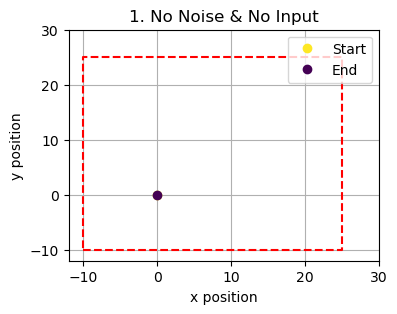

Constraints Violated!!!
Constraints Violated!!!
Constraints Violated!!!
Constraints Violated!!!
Constraints Violated!!!


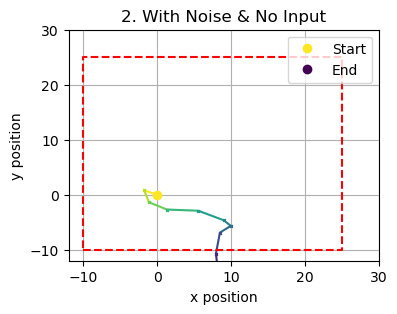

Constraints Violated!!!


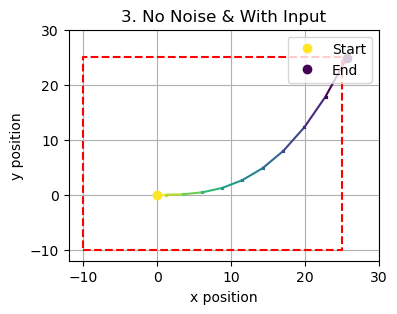

In [49]:
system1 = DoubleIntegrator()
# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0, 0])  # No control input
	system1.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system1.plot_trajectory(fig=fig, ax=ax)
# set the title to 1. No Noise & No Input
ax.set_title('1. No Noise & No Input')
plt.show()

system2 = DoubleIntegrator(sigma=np.eye(4)*0.7)
# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0, 0])  # No control input
	system2.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system2.plot_trajectory(fig=fig, ax=ax)
# set the title to 2. With Noise & No Input
ax.set_title('2. With Noise & No Input')
plt.show()

system3 = DoubleIntegrator()
# Simulate the system for 10 steps
for i in range(10):
	u = np.array([0.23/(i+0.1), 0.175*i])  # Some control input
	system3.step(u)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system3.plot_trajectory(fig=fig, ax=ax)
# set the title to 3. No Noise & With Input
ax.set_title('3. No Noise & With Input')
plt.show()

Lets also try seeing how the system responds to an impulse input.

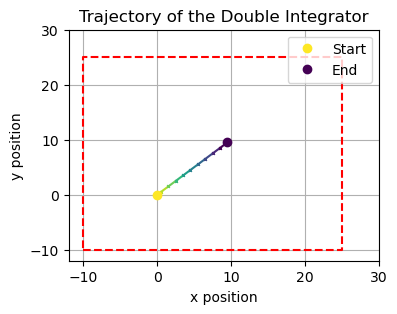

In [50]:
system = DoubleIntegrator()
# Simulate the system for 10 steps
u = np.zeros((10, 2))
u[0, :] = np.ones(2)
for input in u:
	system.step(input)
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
system.plot_trajectory(fig=fig, ax=ax)


### Cost & Constraints
Problem Setup:

We will use default A, B, C, D matrices for the double integrator system.

**Position & Velocity Constraints**: between -10 to 10
**Acceleration Constraints**: between -1 to 1

**Setpoint**: $[0, 0, 0, 0]$

**Initial States** to test: 
1. $[0, 0, 0, 0]$
2. $[0, 0, 0, 5]$
3. $[5, 5, 0, 0]$
4. $[9, -8, -5, -0.5]$

**Prediction Horizon**: 10
**Control Horizon**: 5

**Cost Function**:
$$ J = \sum_{i=0}^{N-1} \left\lVert x_k - x_{ref}\right\rVert_Q^2  + \left\lVert u_k\right\rVert_R^2 $$
Which just simplifies to:
$$ J = \sum_{i=0}^{N-1} \left\lVert x_k\right\rVert_Q^2  + \left\lVert u_k\right\rVert_R^2 $$

**Quadratic cost matrices**:
$Q = I$, $Qf = 5I$ and $R = 2I$

**Noise:**

$\mu = 0$

$\sigma = \begin{bmatrix}
0.01 & 0 &0.01 & 0 \\
0 & 0.01 & 0 & 0.01 \\
0 & 0 & 0.1 & 0 \\
0 & 0 & 0 & 0.1
\end{bmatrix}$


In [51]:

# setpoint = -5*np.array([1, 1, 0, 0])
setpoint = np.array([0, 0, 0, 0])
mu = np.zeros(4)
sigma = np.array([
    [0.01,	0,		0.01,	0],
    [0,		0.01, 	0, 		0.01],
	[0,		0,		0.1,	0],
	[0,		0,		0,		0.1]
                 ]) # I am guessing that noise is more likely in velocity than in position
sigma = (sigma + sigma.T)/2

dt = 1
# initial states:
x01 = np.zeros(4)
x02 = np.array([0, 0, -2, -1])
x03 = np.array([5, 5, 0, 0])
x04 = np.array([9, -8, -5, -0.5])
x05 = np.array([10, 0, 0, 0])

state_box_constraints = np.array([[-10, 10], [-10, 10], [-10, 10], [-10, 10]])
input_box_constraints = np.array([[-1, 1], [-1, 1]])
Q = np.eye(4)
Qf = 5*np.eye(4)
R = 2*np.eye(2)

### MPC Test



In [52]:
def optimalControlInput(system, setpoint, Q, Qf, R, N=10):
	x0 = system.get_state() # current state
	state_box_constraints = system.state_box_constraints
	input_box_constraints = system.input_box_constraints
	setpoint = np.tile(setpoint, N+1) # this is unstacked: [setpoint, setpoint, ..., setpoint], where setpoint = [px, py, vx, vy]

	# setup a cp variable for x0 rolled N times
	x = cp.Variable((x0.size*(N+1))) # this is unstacked: [x0, x1, x2, ..., xN], where xi = [pxi, pyi, vxi, vyi]
	u = cp.Variable((2*N)) # this is unstacked: [u0, u1, u2, ..., uN-1], where ui = [uxi, uyi] # 2 is hardcoded since its a double integrator

	# First, lets setup the cost function
	Q_stacked = sparse.kron(np.eye(N), Q).toarray()
	Q_stacked = sla.block_diag(Q_stacked, Qf)
 
	R_stacked = sparse.kron(sparse.eye(N), R)
	
	cost = cp.quad_form(x - setpoint, Q_stacked) + cp.quad_form(u, R_stacked)
	# setup the constraints

	Ad = system.Ad
	Bd = system.Bd

	# TODO: Setup x_k+1 = A*x_k + B*u_k
	constraints = []
	for k in range(N):
		x_k = x[4 * k:4 * (k + 1)]  # Get state at time k
		x_k_next = x[4 * (k + 1):4 * (k + 2)]  # Get state at time k+1
		u_k = u[2 * k:2 * (k + 1)]  # Get control input at time k
		
		# State transition constraint: x_k+1 = A_d * x_k + B_d * u_k
		constraints.append(x_k_next == Ad @ x_k + Bd @ u_k)
		# add box constraints for the state
		if state_box_constraints is not None:
			for i in range(system.n):
				constraints.append(x_k[i] >= state_box_constraints[i, 0])
				constraints.append(x_k[i] <= state_box_constraints[i, 1])
		# add box constraints for the input
		if input_box_constraints is not None:
			for i in range(system.n):
				constraints.append(u_k[i] >= input_box_constraints[i, 0])
				constraints.append(u_k[i] <= input_box_constraints[i, 1])
		
	# Enforce the initial condition: x_0 = x0 (provided state)
	constraints.append(x[:4] == x0)

	problem = cp.Problem(cp.Minimize(cost), constraints)
	# Solve the problem
	problem.solve()
	if problem.status not in ["optimal", "optimal_inaccurate"]:
		print("Problem not solved optimally:", problem.status)
		return None, None
	optimal_input = u.value.reshape((N, 2))
	return optimal_input

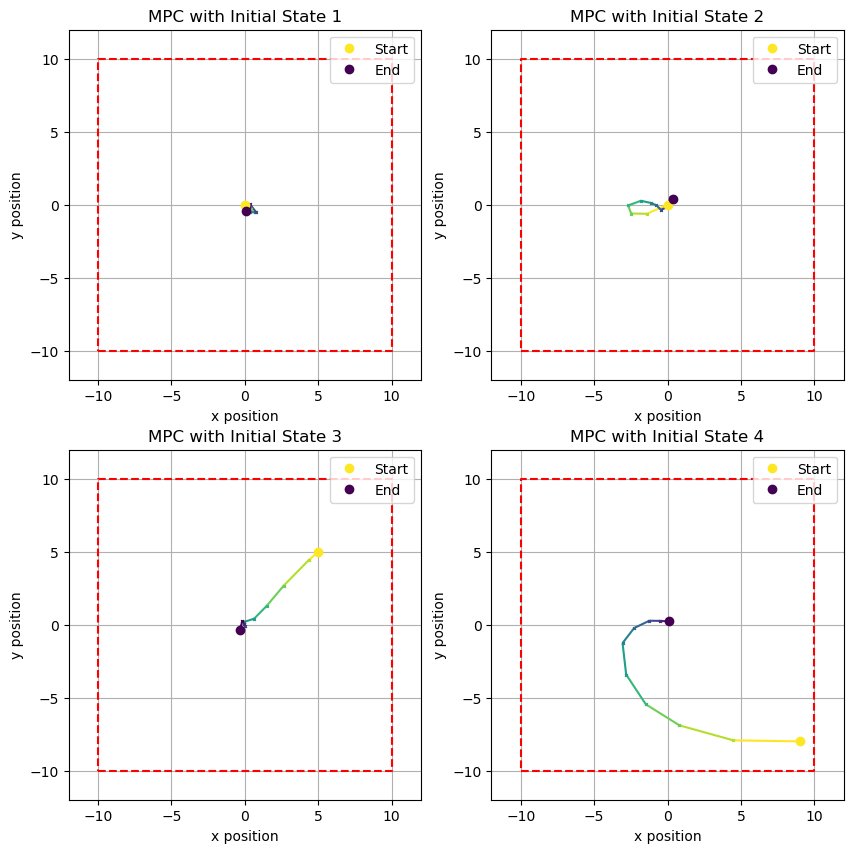

In [53]:
# Create a 2x2 plot
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
for j, initial_state in enumerate([x01, x02, x03, x04]):
	# Create a new system with the initial state
	system = DoubleIntegrator(dt=1, x0=initial_state, state_box_constraints=state_box_constraints, input_box_constraints=input_box_constraints,
						mu=mu, sigma=sigma)

	N = 10
	for i in range(N):
		# Predict the next control input needed
		optimal_input = optimalControlInput(system, setpoint=setpoint, Q=np.eye(4), Qf=5*np.eye(4), R=2*np.eye(2), N=4)
		system.step(optimal_input[0])

	# plot the trajectory
	system.plot_trajectory(fig=fig, ax=axs[j//2, j%2])
	axs[j//2, j%2].set_title(f'MPC with Initial State {j+1}')

plt.show()


## DeePC

In [54]:
def block_hankel(data, L):
	data = data.T
	nmp = data.shape[0] # nmp means the number of n/m/p, aka how many "state"/"input" variables we have
	T = data.shape[1] # T means the number of time steps we have available
	# L is the length of the block hankel matrix, aka context length
	# we need to create:
	# [data[0], data[1], data[2], ... data[T-L]]
	# [data[1], data[2], data[3], ... data[T-L+1]]
	# ...
	# [data[L-1], data[L], data[L+1], ... data[T-1]]
	# we will start by making a 3D tensor of shape (L, T-L+1, nmp)
	block = np.zeros((L, T-L+1, nmp))
	for i in range(L):
		block[i, :, :] = data[:, i:T-L+1+i].T
	# we need to make it such each state var is in the columns, so it should end up being (L*nmp, T-L+1)
	block = block.transpose(0, 2, 1) # this will make it (L, nmp, T-L+1)
	block = block.reshape((L*nmp, T-L+1)) # this will make it (L*nmp, T-L+1)
	return block
		
class DeePC:
	def __init__(self, system, horizon=10, T=100, T_ini=15):
		self.system = system
		self.n = self.system.n # this is the number of axes: 2 for 2D
		self.input_shape = self.system.input_shape # this is 2 for a 2D system
		self.output_shape = self.system.output_shape # this is 4 for a 2D system
		self.default_state_box_constraints = self.system.state_box_constraints
		self.default_input_box_constraints = self.system.input_box_constraints
  
		self.horizon = horizon  # prediction horizon
		self.T = T  # length of the input sequence
		self.T_ini = T_ini  # length of the input sequence for the initial condition

		# offline data collection storage
		self.U_off_list = []  # Control inputs
		self.Y_off_list = []  # Outputs
		self.U_off_data = None # Numpy array of control inputs
		self.Y_off_data = None

		# online data list
		self.U_on_list = []
		self.Y_on_list = []
		self.u_ini = None # Numpy array of control inputs
		self.y_ini = None

		# Hankel matrices
		self.Hu = None
		self.Hy = None

		self.Up = None
		self.Uf = None
		self.Yp = None
		self.Yf = None

	def disable_box_constraints(self):
		# disable box constraints
		self.system.state_box_constraints = None
		self.system.input_box_constraints = None
  
	def enable_box_constraints(self):
		self.system.state_box_constraints = self.default_state_box_constraints
		self.system.input_box_constraints = self.default_input_box_constraints

  
	def collect_offline_data(self):
		# first, disable the box constraints so that we can collect data
		self.disable_box_constraints()
		# Collect data for DeePC by creating a random input sequence
		# U = np.random.uniform(-0.1, 0.1, (self.T, system.n))
		# for stability, we will use a very specific input sequence
		# we will generate self.T//2 steps: [u0, u1... uT//2-1]
		# then for rich excitation, we will flip the sign and randomly repeat the sequency
		# Ex: [u0, u1, u2, -u0, u3, -u1, u4, -u2, u5, -u3... uT//2-1, -uT//2-2, -uT//2-1]

		U_pos = np.random.uniform(-1, 1, (self.T//2, self.n))

		U_neg = -U_pos.copy()
		pos_neg_weight = 0.7
		U = []
		for i in range(self.T):
			# randomly select either U_pos or U_neg, weighted by the number of steps left, so it would be np.random.rand() > U_pos.shape[0] / (U_pos.shape[0] + U_neg.shape[0])
			if ((1-pos_neg_weight)/2 + pos_neg_weight*np.random.rand()) < U_pos.shape[0] / (U_pos.shape[0] + U_neg.shape[0]):
				U.append(U_pos[0])
				# remove the first element from U_pos
				U_pos = U_pos[1:]
			else:
				U.append(U_neg[0])
				# remove the first element from U_neg
				U_neg = U_neg[1:]

		U = np.array(U)

		for u in U:
			# set the state
			self.Y_off_list.append(self.system.y)
			self.system.step(u)
			self.U_off_list.append(u)
		
		self.U_off_data = np.array(self.U_off_list)
		self.Y_off_data = np.array(self.Y_off_list)
  
		# now, we can restore the box constraints
		self.enable_box_constraints()
  
	def step_and_collect(self, u):
		# this will step and collect online data

		self.U_on_list.append(u)
		self.system.step(u)
		self.Y_on_list.append(self.system.y)
  
  
		# we only need the last T_ini steps of data
		self.U_on_list = self.U_on_list[-self.T_ini:]
		self.Y_on_list = self.Y_on_list[-self.T_ini:]
		self.u_ini = np.array(self.U_on_list).flatten()
		self.y_ini = np.array(self.Y_on_list).flatten()

	def build_hankel(self):
		# build the hankel matrices from the offline data
		L = self.horizon + self.T_ini
		self.Hu = block_hankel(self.U_off_data, L)
		self.Hy = block_hankel(self.Y_off_data, L)

		m, p = self.input_shape, self.output_shape
		self.Up = self.Hu[:m * self.T_ini, :]
		self.Uf = self.Hu[m * self.T_ini:, :]
		self.Yp = self.Hy[:p * self.T_ini, :]
		self.Yf = self.Hy[p * self.T_ini:, :]

	def solve(self, setpoint, Q=None, Qf=None, R=None, Lg=1e-6, Ly = 1e-6):
		m, p = self.input_shape, self.output_shape

		setpoint = np.tile(setpoint, self.horizon) # this is unstacked: [setpoint, setpoint, ..., setpoint], where setpoint = [px, py, vx, vy]

		# setup a cp variable for x0 rolled N times
		u = cp.Variable((m*(self.horizon)))
		y = cp.Variable((p*(self.horizon)))
		g = cp.Variable((self.Up.shape[1]))
		sigma_y = cp.Variable((self.Yp.shape[0]))
		sigma_u = cp.Variable((self.Up.shape[0]))

		# First, lets setup the cost function
		Q_stacked = sparse.kron(np.eye(self.horizon-1), Q).toarray()
		Q_stacked = sla.block_diag(Q_stacked, Qf)
		R_stacked = sparse.kron(sparse.eye(self.horizon), R)

		cost = cp.quad_form(y - setpoint, Q_stacked) + cp.quad_form(u, R_stacked) + Lg * cp.norm1(g) + Ly * cp.norm1(sigma_y)
		# print the shape of the cost

		# setup the constraints
		constraints = [
			self.Up @ g == cp.vec(self.u_ini, order='F'),
			self.Yp @ g + sigma_y == cp.vec(self.y_ini, order='F'),
			self.Uf @ g == u,
			self.Yf @ g == y,
		]
  
		# True MPC constraints
		# Ad, Bd = self.system.Ad, self.system.Bd
  
		# x_0 = self.y_ini[-self.system.state_shape:]  # Get the last state from the initial condition
		# x_0_next = y[:Ad.shape[1]]
		# u_0 = u[:Bd.shape[1]]  # Get the control input at time 0
		# constraints.append(x_0_next == Ad @ x_0 + Bd @ u_0)  # Initial state transition constraint
		# for k in range(1, N):
		# 	x_k = y[Ad.shape[1] * (k-1):Ad.shape[1] * (k)]  # Get state at time k
		# 	x_k_next = y[Ad.shape[1] * (k):Ad.shape[1] * (k + 1)]  # Get state at time k+1
		# 	u_k = u[Bd.shape[1] * k:Bd.shape[1] * (k + 1)]  # Get control input at time k
			
		# 	# State transition constraint: x_k+1 = A_d * x_k + B_d * u_k
		# 	constraints.append(x_k_next == Ad @ x_k + Bd @ u_k)


		# print the rank of Yp and compare it with shape
		# print("Rank of Yp:", nla.matrix_rank(self.Yp))
		# print("Shape of Yp:", self.Yp.shape)
		# add box constraints for the state
		if self.system.state_box_constraints is not None:
			for i in range(self.n):
				constraints.append(u[i] >= self.system.state_box_constraints[i, 0])
				constraints.append(u[i] <= self.system.state_box_constraints[i, 1])
		# add box constraints for the input
		if self.system.input_box_constraints is not None:
			for i in range(self.n):
				constraints.append(u[i] >= self.system.input_box_constraints[i, 0])
				constraints.append(u[i] <= self.system.input_box_constraints[i, 1])
  
		prob = cp.Problem(cp.Minimize(cost), constraints)
		prob.solve(solver=cp.SCS)

		if prob.status not in ["optimal", "optimal_inaccurate"]:
			print("Problem not solved optimally:", prob.status)
			return None, None


		# Reshape and return
		u_opt = u.value.reshape(self.horizon, m)
		y_opt = y.value.reshape(self.horizon, p)
		return u_opt, y_opt

In [55]:
s = 3
T_INI = 5
T = 200
HORIZON = 30
LAMBDA_G_REGULARIZER = 0
LAMBDA_Y_REGULARIZER = 1000

#### Offline Data Collection

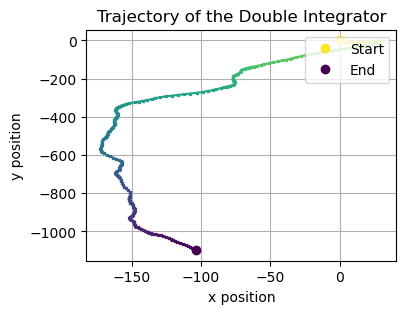

In [56]:
system = DoubleIntegrator(sigma=sigma)
# Data Collection parameters
horizon = 10
T = 250
T_ini = 1
deepc = DeePC(system, horizon=horizon, T=T, T_ini=T_ini) # create an instance of DeePC


# collect data
deepc.collect_offline_data()
# Lets see what that trajectory looked like and see if it was rich enough
fig, ax = plt.subplots()
fig.set_size_inches(4, 3)
deepc.system.plot_trajectory(fig=fig, ax=ax, limit_chart=False)
# If this worked correctly, we should see a trajectory that is not too far from the origin

### Testing the Implicit Model 
We need a way to check if the implicit model is correctly learned. Lets test how that works

First we will try System ID: 

$x_{k+1} = Ax + Bu$

So we can say:

$\mathcal{X}_f \approx A\mathcal{X}_p + B\mathcal{U}_p$

$\begin{bmatrix} A & B \end{bmatrix} \approx \mathcal{X_f} \begin{bmatrix} \mathcal{X_p} \\ \mathcal{U_p} \end{bmatrix}^{\dagger}$

Shape of Yp: (4, 240)
Shape of Up: (2, 240)
Estimated A and B matrices:


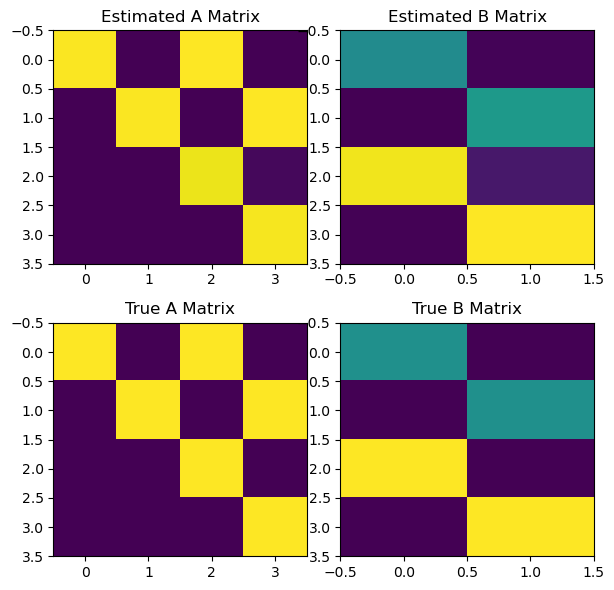

Estimated A matrix:
 [[ 1.    0.    1.    0.  ]
 [-0.    1.    0.    1.  ]
 [-0.   -0.    0.97  0.02]
 [ 0.   -0.    0.    0.99]]
True A matrix:
 [[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Estimated B matrix:
 [[ 0.46  0.  ]
 [-0.01  0.51]
 [ 0.94  0.06]
 [ 0.    0.96]]
True B matrix:
 [[0.5 0. ]
 [0.  0.5]
 [1.  0. ]
 [0.  1. ]]
A matrix error: 0.03741657386773944
B matrix error: 0.10295630140987004


In [57]:
# Lets try to extract the AB matricies from the Past Hankel matrix
deepc.build_hankel()
Yp = deepc.Yp
Up = deepc.Up
print("Shape of Yp:", Yp.shape)
print("Shape of Up:", Up.shape)

Xf = deepc.Yf[:Yp.shape[0], :]

XpUp = np.vstack([Yp, Up])

XpUp_inv = nla.pinv(XpUp)
AB_est = Xf @ XpUp_inv
A_est = AB_est[:, :Yp.shape[0]]
B_est = AB_est[:, Yp.shape[0]:]
print("Estimated A and B matrices:")
# imshow the A & B matrices
# create a figure with 2 subplots
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(6, 6)
# the estimated A & B matrices
ax[0, 0].imshow(A_est, cmap='viridis', aspect='auto')
ax[0, 0].set_title('Estimated A Matrix')
ax[0, 1].imshow(B_est, cmap='viridis', aspect='auto')
ax[0, 1].set_title('Estimated B Matrix')
# the true A & B matrices
ax[1, 0].imshow(system.Ad, cmap='viridis', aspect='auto')
ax[1, 0].set_title('True A Matrix')
ax[1, 1].imshow(system.Bd, cmap='viridis', aspect='auto')
ax[1, 1].set_title('True B Matrix')
plt.tight_layout()
plt.show()
# print only 2 decimal places
A_est = np.round(A_est, 2)
B_est = np.round(B_est, 2)
print("Estimated A matrix:\n", A_est)
print("True A matrix:\n", system.Ad)

print("Estimated B matrix:\n", B_est)
print("True B matrix:\n", system.Bd)

# print metrics
print("A matrix error:", nla.norm(A_est - system.Ad))
print("B matrix error:", nla.norm(B_est - system.Bd))

### Running the DeePC

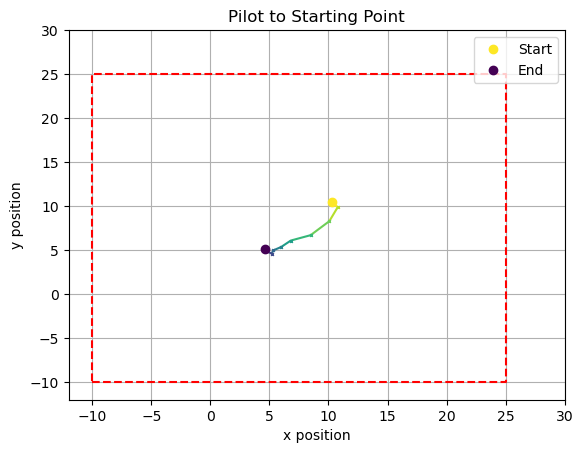

In [58]:
# initial state estimation
# we will try to "drive" the system to its setpoint using MPC and then starting there we will use DeePC to control the system
# use x01 as the setpoint, and whatever the system is currently at as the initial state
# We will also plot it to make sure things work

# * The following code is copied from the MPC code above

# system = DoubleIntegrator(dt=1, x0=initial_state, state_box_constraints=state_box_constraints, input_box_constraints=input_box_constraints,
# 						mu=mu, sigma=sigma)
# * ^ we do not need to create a new system, since we already have one that we want to use.


def steerDeePCwithMPC(deepcController, true_start, des_start, Q=np.eye(4), Qf=5*np.eye(4), R=2*np.eye(2), N=10, horizon=4, store_past=None, plot=True):
	# set the initial state
	deepcController.system.set_state(true_start)
	for i in range(N):
		optimal_input = optimalControlInput(deepcController.system, setpoint=des_start, Q=Q, Qf=Qf, R=R, N=min(N - i, horizon))
		deepcController.step_and_collect(optimal_input[0])
		
	# however, we want to bring it to a reasonable state from which we can drive it to the setpoint, while still collecting rich data to estimate the current state
	# erase all past trajectory before we started going back to setpoint(aka keep the last N steps)
	if store_past is not None:
		deepc.system.state_history = deepc.system.state_history[-store_past:]
		deepc.system.input_history = deepc.system.input_history[- store_past:]
		deepc.system.output_history = deepc.system.output_history[- store_past:]
	if plot:
		# plot the trajectory
		fig, ax = plt.subplots()
		deepc.system.plot_trajectory(fig=fig, ax=ax)
		ax.set_title(f'Pilot to Starting Point')
		
extra_steps = 10
true_start = np.array([10, 10, 1, 1])
steerDeePCwithMPC(deepc, true_start=true_start, des_start=x03, Q=Q, Qf=Qf, R=R, N=T_ini + extra_steps, horizon=5, store_past=deepc.T_ini + extra_steps)

In [59]:
print(deepc.U_off_data.shape)
print(deepc.Y_off_data.shape)
print(deepc.u_ini.shape)
print(deepc.y_ini.shape)

(250, 2)
(250, 4)
(2,)
(4,)


In [60]:
# lets check if we collected data correctly: check the shapes of the data
print("U_off_data shape:", deepc.U_off_data.shape)
print("Y_off_data shape:", deepc.Y_off_data.shape)

U_off_data shape: (250, 2)
Y_off_data shape: (250, 4)


awesome

In [61]:
# verify system is approximately at the starting point
print(x03)
print("System state:", deepc.system.get_state())

[5 5 0 0]
System state: [ 4.62654369  5.11300898 -0.2365101  -0.122393  ]


Now we can create the implicit models

Hu shape: (22, 240)
Hy shape: (44, 240)
Up shape: (2, 240)
Uf shape: (20, 240)
Yp shape: (4, 240)
Yf shape: (40, 240)


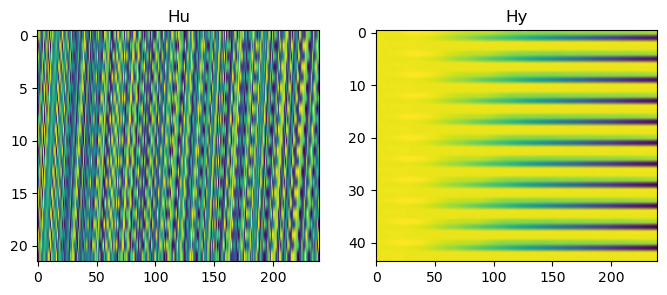

In [62]:
deepc.build_hankel()
# print the shapes of the Hankel matrices
print("Hu shape:", deepc.Hu.shape)
print("Hy shape:", deepc.Hy.shape)
print("Up shape:", deepc.Up.shape)
print("Uf shape:", deepc.Uf.shape)
print("Yp shape:", deepc.Yp.shape)
print("Yf shape:", deepc.Yf.shape)
# Lets visually check if the Hankel matrices are correct
# 2x1 plot
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
# imshow Hu on the first axis
axs[0].imshow(deepc.Hu, aspect='auto', cmap='viridis')
axs[0].set_title('Hu')
# imshow Hy on the second axis
axs[1].imshow(deepc.Hy, aspect='auto', cmap='viridis')
axs[1].set_title('Hy')
plt.show()

And now lets test it out!

u: [-0.70827961 -1.00000001]
u: [-0.37082722  0.63986931]
u: [-0.08011761 -0.44428035]
u: [-0.04739897  0.65282216]
u: [-0.0573999  -0.52699211]
u: [-0.08310182  0.58555225]
u: [-0.26408666 -0.16114676]
u: [-0.32406243  0.45177904]
u: [0.14629163 0.3483138 ]
u: [0.17026218 0.04955755]


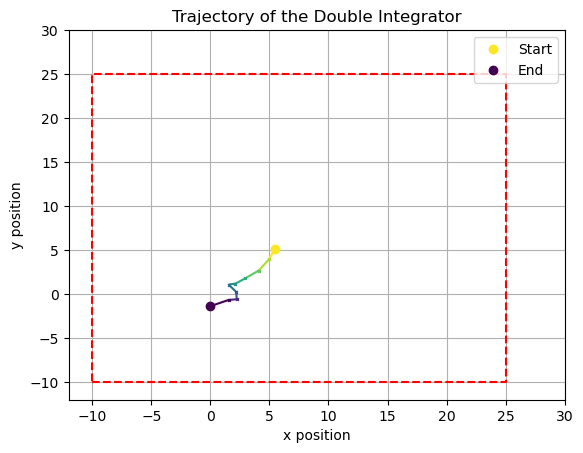

In [63]:
# start by going to the setpoint
steerDeePCwithMPC(deepc, true_start=true_start, des_start=x03, Q=Q, Qf=Qf, R=R, N=T_ini + extra_steps, horizon=5, store_past=deepc.T_ini + extra_steps, plot=False)

# Now that you have u_opt and y_opt, apply the control inputs to the system
# and plot the trajectory
system.sigma = np.eye(4)*0.1 # set the noise to be the same as before
# Simulate the system for N steps
setpoint = np.zeros(4)
# clear the histories
deepc.system.input_history = []
deepc.system.state_history = []
deepc.system.output_history = []
for i in range(horizon):
	deepc.build_hankel()
	# Solve DeePC
	u_opt, y_opt = deepc.solve(setpoint, Q=Q, Qf=Qf, R=R, Lg=20, Ly=1e4)
	u = u_opt[0]
	print("u:", u)
	deepc.step_and_collect(u)
fig, ax = plt.subplots()
system.plot_trajectory(fig=fig, ax=ax)
plt.show()